<img src="../img/AutoScout.jpg" alt="scout" style="width: 700px; display: block; margin-left: auto; margin-right: auto;"/>

In [54]:
import pandas as pd
import numpy as np
from sklearn.calibration import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [45]:
data = pd.read_csv('../data/raw/car_prices-EU.csv')
data

,Brand,Model,Price,Country,Kilometers,Gearbox,Year,Fuel,Power,Seller,Body Type,Type,Drivetrain,Seats,Doors,Cylinders,Color,Upholstery
0,Fiat,Freemont,5100.0,IT,225282,Automatic,2013,Diesel,170.0,Dealer,Van,Used,4WD,7.0,5.0,4.0,Black,Full leather
1,Fiat,Panda,1995.0,NL,162076,Manual,2010,Gasoline,69.0,Dealer,Compact,Used,Front,4.0,5.0,4.0,Grey,Cloth
2,Fiat,Panda,2995.0,NL,53914,Manual,2006,Gasoline,60.0,Dealer,Compact,Used,Front,4.0,5.0,4.0,Black,NaN
3,Fiat,Grande Punto,1450.0,NL,238642,Manual,2006,Gasoline,95.0,Dealer,Compact,Used,Front,5.0,5.0,4.0,Black,Cloth
4,Fiat,500X,8900.0,IT,199000,Manual,2017,LPG,120.0,Dealer,Off-Road/Pick-up,Used,Front,5.0,5.0,4.0,White,Part leather
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12899,Corvette,C7,65000.0,DE,20064,NaN,2015,Gasoline,466.0,Private seller,Coupe,Used,NaN,2.0,3.0,NaN,Blue,Velour
12900,Corvette,C8,144900.0,AT,3500,Automatic,2021,Electric/Gasoline,503.0,Dealer,Convertible,Used,Rear,2.0,2.0,NaN,Blue,Full leather
12901,Corvette,Z06,70500.0,DE,29874,Automatic,2015,Gasoline,659.0,Dealer,Convertible,Used,NaN,2.0,2.0,NaN,Blue,Full leather
12902,Corvette,C3,21800.0,AT,85000,Manual,1971,Gasoline,277.0,Private seller,Convertible,Used,Rear,2.0,2.0,8.0,Yellow,Other


In [46]:
df = data.copy()

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12904 entries, 0 to 12903
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Brand       12904 non-null  object 
 1   Model       12821 non-null  object 
 2   Price       12894 non-null  float64
 3   Country     12894 non-null  object 
 4   Kilometers  12771 non-null  object 
 5   Gearbox     12813 non-null  object 
 6   Year        12429 non-null  object 
 7   Fuel        12895 non-null  object 
 8   Power       12792 non-null  float64
 9   Seller      12902 non-null  object 
 10  Body Type   12904 non-null  object 
 11  Type        12903 non-null  object 
 12  Drivetrain  9750 non-null   object 
 13  Seats       12297 non-null  float64
 14  Doors       12639 non-null  float64
 15  Cylinders   10161 non-null  float64
 16  Color       12406 non-null  object 
 17  Upholstery  11094 non-null  object 
dtypes: float64(5), object(13)
memory usage: 1.8+ MB


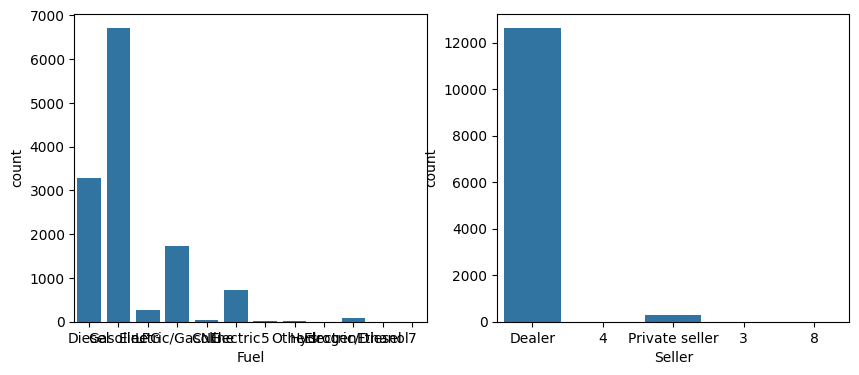

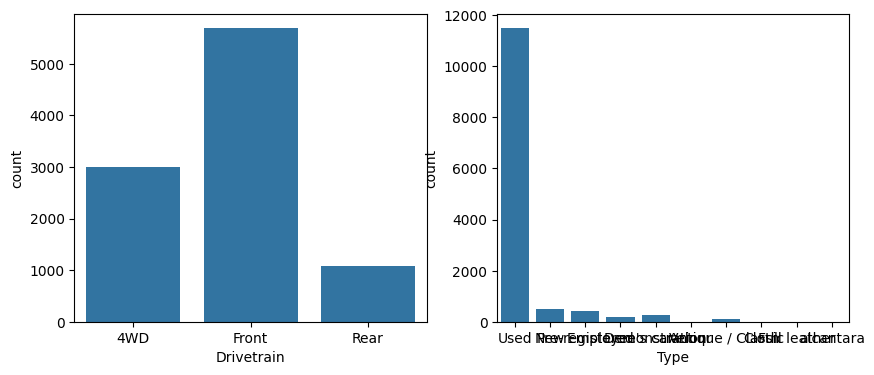

In [48]:
cat_cols = ['Fuel','Seller','Drivetrain','Type']
i=0
while i < 4:
    fig = plt.figure(figsize=[10,4])
    plt.subplot(1,2,1)
    sns.countplot(x=cat_cols[i], data=df)
    i += 1
    
    plt.subplot(1,2,2)
    sns.countplot(x=cat_cols[i], data=df)
    i += 1
    
    plt.show()

### Normalizar las columnas Brand y Model
Guardar en el dataframe otra columna con valores decimales donde la parte entera coresponda a un codigo que asignamos para las marcas de coches teniendo en cuenta la frecuencia de cada marca, siendo 1 la marca más repetida y 38 la marca menos repetida, y la parte decimal que coresponda al modelo de coche de esta marca teniendo en cuenta el precio medio de estos modelos, siendo .001 el modelo más barato.

In [49]:
# borrar las lineas que tienen NaN en modelo
df = df.dropna(subset = ['Model'])

# Calcular frecuencia de cada marca
brand_counts = df.groupby('Brand')['Price'].mean().sort_values()

# Crear mapeo: más frecuente → número más bajo
frequency_order = brand_counts.index.tolist()
encoding_dict = {brand: i for i, brand in enumerate(frequency_order)}

# Añadir una columna numerica para el Brand
df.insert(1, 'Brand_c' , df['Brand'].map(encoding_dict))


# Calcular precio promedio por modelo
precio_promedio_modelo = df.groupby(['Brand_c', 'Model'])['Price'].mean().reset_index()

# Normalizar precios por marca
def normalizar_por_marca(grupo):
    precio_min = grupo['Price'].min()
    precio_max = grupo['Price'].max()
    rango = precio_max - precio_min
    
    if rango > 0:
        return 0.001 + 0.998 * (grupo['Price'] - precio_min) / rango
    else:
        n = len(grupo)
        return [0.001 + i * (0.998 / (n - 1)) for i in range(n)] if n > 1 else [0.5]

precio_promedio_modelo['Model_decimal'] = precio_promedio_modelo.groupby('Brand_c')['Price'].transform(
    lambda x: normalizar_por_marca(pd.DataFrame({'Price': x}))
)

# Crear nueva columna de nr. decimales, donde la parte entera es el codigo del Brand y la parte decimal el codigo del Model
precio_promedio_modelo['Brand_Model_code'] = (precio_promedio_modelo['Brand_c'] + precio_promedio_modelo['Model_decimal'].round(3))

# 5. Mapear al DataFrame original
codigo_map = precio_promedio_modelo.set_index(['Brand_c', 'Model'])['Brand_Model_code'].to_dict()
df['Brand_Model_code'] = df.apply(lambda r: codigo_map[(r['Brand_c'], r['Model'])], axis=1)


In [50]:
df[df['Model']=='Punto']

,Brand,Brand_c,Model,Price,Country,Kilometers,Gearbox,Year,Fuel,Power,Seller,Body Type,Type,Drivetrain,Seats,Doors,Cylinders,Color,Upholstery,Brand_Model_code
9,Fiat,0,Punto,6900.0,IT,89700,Manual,2016,Gasoline,69.0,Dealer,Sedan,Used,Front,5.0,5.0,4.0,Grey,NaN,0.119
33,Fiat,0,Punto,5900.0,IT,54773,Manual,2012,Gasoline,69.0,Dealer,Compact,Used,Front,5.0,3.0,4.0,Blue,Cloth,0.119
52,Fiat,0,Punto,5950.0,IT,59000,Manual,2010,Gasoline,60.0,Dealer,Sedan,Used,Front,5.0,5.0,4.0,Silver,NaN,0.119
65,Fiat,0,Punto,3980.0,BE,105662,Manual,2008,Diesel,69.0,Dealer,Sedan,Used,NaN,5.0,5.0,4.0,Black,Cloth,0.119
79,Fiat,0,Punto,6900.0,IT,89700,Manual,2016,Gasoline,69.0,Dealer,Sedan,Used,Front,5.0,5.0,4.0,Grey,NaN,0.119
153,Fiat,0,Punto,5900.0,IT,129900,Manual,2012,CNG,69.0,Dealer,Sedan,Used,Front,5.0,5.0,4.0,White,Cloth,0.119
173,Fiat,0,Punto,8890.0,IT,73000,Manual,2018,LPG,77.0,Dealer,Sedan,Used,NaN,5.0,5.0,4.0,NaN,NaN,0.119
198,Fiat,0,Punto,7490.0,IT,63000,Semi-automatic,2014,Gasoline,69.0,Dealer,Sedan,Used,Front,5.0,5.0,4.0,Grey,Cloth,0.119
274,Fiat,0,Punto,7499.0,IT,122000,Manual,2017,Diesel,95.0,Dealer,Sedan,Used,NaN,5.0,5.0,4.0,White,Cloth,0.119
283,Fiat,0,Punto,4490.0,IT,199000,Manual,2015,Diesel,75.0,Dealer,Sedan,Used,Front,5.0,5.0,4.0,Black,Cloth,0.119


In [51]:
df[df['Brand']=='Toyota'].sort_values('Brand_Model_code')

,Brand,Brand_c,Model,Price,Country,Kilometers,Gearbox,Year,Fuel,Power,Seller,Body Type,Type,Drivetrain,Seats,Doors,Cylinders,Color,Upholstery,Brand_Model_code
4193,Toyota,10,iQ,4990.0,DE,110650,Manual,2010,Gasoline,68.0,Dealer,Sedan,Used,Front,4.0,3.0,3.0,White,Cloth,10.001
4146,Toyota,10,Corolla Verso,5999.0,DE,147000,Automatic,2006,Gasoline,129.0,Dealer,Van,Used,Front,7.0,5.0,4.0,Blue,Cloth,10.004
4383,Toyota,10,Corolla Verso,4250.0,DE,199925,Manual,2007,Diesel,177.0,Dealer,Van,Used,Front,7.0,5.0,4.0,Silver,Cloth,10.004
4214,Toyota,10,Urban Cruiser,5939.0,NL,165067,Manual,2009,Gasoline,101.0,Dealer,Compact,Used,Front,5.0,5.0,4.0,Violet,Cloth,10.021
4330,Toyota,10,Aygo,8500.0,IT,49000,Manual,2018,Gasoline,69.0,Dealer,Sedan,Used,Front,4.0,5.0,3.0,Grey,Cloth,10.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4169,Toyota,10,Land Cruiser,78780.0,DE,400,Automatic,2024,Diesel,205.0,Dealer,Off-Road/Pick-up,Used,4WD,5.0,5.0,4.0,Grey,Full leather,10.706
4332,Toyota,10,Land Cruiser,75990.0,BE,56,Automatic,2024,Diesel,204.0,Dealer,Off-Road/Pick-up,Used,4WD,5.0,5.0,NaN,White,Full leather,10.706
4109,Toyota,10,Land Cruiser,13950.0,NL,302037,Automatic,2000,Gasoline,178.0,Dealer,Off-Road/Pick-up,Used,4WD,5.0,5.0,6.0,Grey,Full leather,10.706
4102,Toyota,10,Land Cruiser,18900.0,IT,370500,Automatic,2010,Diesel,173.0,Dealer,Off-Road/Pick-up,Used,4WD,5.0,3.0,4.0,Grey,Cloth,10.706


Comprobar que se ha guardado correctamente.
<br> En el siguiente ejemplo observamos que la marca Toyota se ha guardaro con el codigo 10, y el coche menos caro de esta marca tiene el codigo 10.001

In [52]:
df[df['Brand_Model_code'] == 10.001][['Brand','Brand_c','Model','Price','Brand_Model_code']]

,Brand,Brand_c,Model,Price,Brand_Model_code
4193,Toyota,10,iQ,4990.0,10.001


In [28]:
# borrar las lineas que tienen más de 3 columnas vacias
df = df[df.isna().sum(axis=1) <= 3]

# cambiar el año a 2025 y los kilometros a 0 si no existen y el coche es de tipo nuevo
df.loc[df['Year'].isna() & (df['Type'] == 'New') & (df['Kilometers'].isna()), 'Kilometers'] = 0
df.loc[df['Year'].isna() & (df['Type'] == 'New'), 'Year'] = 2025

# Borrar las lineas que no tienen año ni modelo
df = df.dropna(subset=['Year'])
df = df.dropna(subset= ['Model'])

df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
# Si es antiguo (<=2013) y no tiene Gearbox, asumir Manual
df.loc[df['Gearbox'].isna() & (df['Year'] <= 2013), 'Gearbox'] = 'Manual'

# Si es moderno (>2013) y no tiene Gearbox, asumir Automatic
df.loc[df['Gearbox'].isna() & (df['Year'] > 2013), 'Gearbox'] = 'Automatic'

# añadir la moda
df['Fuel'] = df['Fuel'].fillna(df['Fuel'].mode()[0])

df.loc[df['Drivetrain'].isna() & (df['Power'] <= 200), 'Drivetrain'] = 'Front'
df.loc[df['Drivetrain'].isna() & (df['Power'] > 200), 'Drivetrain'] = '4WD'

# sustituir NaN con la moda
df['Seats'] = df['Seats'].fillna(df['Seats'].mode()[0])
df['Doors'] = df['Doors'].fillna(df['Doors'].mode()[0])
df['Upholstery'] = df['Upholstery'].fillna(df['Upholstery'].mode()[0])
df['Color'] = df['Color'].fillna(df['Color'].mode()[0])

# cambiar el tipo de la columna km de object a float
df['Kilometers'] = df['Kilometers'].astype(float)


In [29]:
mapping = {cat: i for i, cat in enumerate(df['Country'].value_counts().index)}
df['Country_c'] = df['Country'].map(mapping)

mapping = {cat: i for i, cat in enumerate(df['Gearbox'].value_counts().index)}
df['Gearbox_c'] = df['Gearbox'].map(mapping)

mapping = {cat: i for i, cat in enumerate(df['Fuel'].value_counts().index)}
df['Fuel_c'] = df['Fuel'].map(mapping)

mapping = {cat: i for i, cat in enumerate(df['Seller'].value_counts().index)}
df['Seller_c'] = df['Seller'].map(mapping)

mapping = {cat: i for i, cat in enumerate(df['Type'].value_counts().index)}
df['Type_c'] = df['Type'].map(mapping)

mapping = {cat: i for i, cat in enumerate(df['Drivetrain'].value_counts().index)}
df['Drivetrain_c'] = df['Drivetrain'].map(mapping)

mapping = {cat: i for i, cat in enumerate(df['Upholstery'].value_counts().index)}
df['Upholstery_c'] = df['Upholstery'].map(mapping)

mapping = {cat: i for i, cat in enumerate(df['Color'].value_counts().index)}
df['Color_c'] = df['Color'].map(mapping)

mapping = {cat: i for i, cat in enumerate(df['Body Type'].value_counts().index)}
df['Body_Type_c'] = df['Body Type'].map(mapping)

In [ ]:
# mostrar el dataset sin limite de columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df[df['Country']=='ES']

,Brand,Brand_c,Model,Price,Country,Kilometers,Gearbox,Year,Fuel,Power,Seller,Body Type,Type,Drivetrain,Seats,Doors,Cylinders,Color,Upholstery,Brand_Model_code,Country_c,Gearbox_c,Fuel_c,Seller_c,Type_c,Drivetrain_c,Upholstery_c,Color_c,Body_Type_c
368,Fiat,0,Panda,10950.0,ES,68000.0,Manual,2018,Diesel,95.0,Dealer,Compact,Used,4WD,4.0,5.0,4.0,Grey,Cloth,0.181,5,1,1,0,0,1.0,0,1,2
488,Citroen,2,C5,1300.0,ES,566000.0,Manual,2002,Diesel,109.0,Dealer,Sedan,Used,Front,5.0,5.0,4.0,Violet,Cloth,2.245,5,1,1,0,0,0.0,0,11,1
619,Citroen,2,C4,4500.0,ES,175000.0,Manual,2010,Diesel,111.0,Dealer,Van,Used,Front,7.0,5.0,4.0,Grey,Cloth,2.570,5,1,1,0,0,0.0,0,1,5
648,Citroen,2,C4 Cactus,5495.0,ES,130000.0,Manual,2014,Gasoline,82.0,Dealer,Compact,Used,Front,5.0,5.0,3.0,Yellow,Cloth,2.373,5,1,0,0,0,0.0,0,10,2
725,Citroen,2,C6,5500.0,ES,199000.0,Automatic,2007,Diesel,208.0,Dealer,Sedan,Used,Front,5.0,4.0,6.0,Grey,Cloth,2.165,5,0,1,0,0,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12647,Bentley,33,Azure,98000.0,ES,45200.0,Automatic,1998,Gasoline,389.0,Dealer,Convertible,Used,Rear,4.0,2.0,8.0,Blue,Cloth,33.029,5,0,0,0,0,2.0,0,3,6
12654,Bentley,33,Continental,268000.0,ES,8300.0,Automatic,2023,Gasoline,549.0,Dealer,Convertible,Used,4WD,4.0,2.0,8.0,Grey,Cloth,33.046,5,0,0,0,0,1.0,0,1,6
12657,Bentley,33,Continental,317000.0,ES,8900.0,Automatic,2023,Gasoline,659.0,Dealer,Convertible,Used,4WD,4.0,2.0,12.0,Black,Cloth,33.046,5,0,0,0,0,1.0,0,0,6
12690,Rolls-Royce,35,Phantom,170000.0,ES,108000.0,Automatic,2008,Gasoline,460.0,Dealer,Sedan,Used,Rear,5.0,4.0,12.0,Grey,Cloth,35.403,5,0,0,0,0,2.0,0,1,1


In [32]:
# Borrar las columnas no numericas e innecesarias
df = df.drop(columns=['Brand', 'Model', 'Country','Cylinders','Gearbox','Fuel','Seller','Body Type', 'Type', 'Drivetrain', 'Color', 'Upholstery', 'Power'])

In [33]:
# Comprobamos como ha quedado el DataFrame antes de guardarlo
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12415 entries, 0 to 12903
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brand_c           12415 non-null  int64  
 1   Price             12415 non-null  float64
 2   Kilometers        12415 non-null  float64
 3   Year              12415 non-null  int64  
 4   Seats             12415 non-null  float64
 5   Doors             12415 non-null  float64
 6   Brand_Model_code  12415 non-null  float64
 7   Country_c         12415 non-null  int64  
 8   Gearbox_c         12415 non-null  int64  
 9   Fuel_c            12415 non-null  int64  
 10  Seller_c          12415 non-null  int64  
 11  Type_c            12415 non-null  int64  
 12  Drivetrain_c      12411 non-null  float64
 13  Upholstery_c      12415 non-null  int64  
 14  Color_c           12415 non-null  int64  
 15  Body_Type_c       12415 non-null  int64  
dtypes: float64(6), int64(10)
memory usage: 1.6 MB

In [34]:
df = df.dropna()

In [35]:
df.describe()

,Brand_c,Price,Kilometers,Year,Seats,Doors,Brand_Model_code,Country_c,Gearbox_c,Fuel_c,Seller_c,Type_c,Drivetrain_c,Upholstery_c,Color_c,Body_Type_c
count,12411.000000,1.241100e+04,1.241100e+04,12411.000000,12411.000000,12411.000000,12411.000000,12411.000000,12411.000000,12411.000000,12411.000000,12411.000000,12411.000000,12411.00000,12411.000000,12411.000000
mean,15.601885,3.298163e+04,8.166189e+04,2017.444122,4.896785,4.499799,15.924650,1.174925,0.419950,0.854484,0.019821,0.232536,0.467569,0.83281,1.882926,1.432036
std,9.623827,8.365175e+04,7.374818e+04,7.498074,0.810824,0.927629,9.597074,1.430789,0.516077,1.154649,0.139391,0.787027,0.646175,1.09287,2.148832,1.781800
min,0.000000,3.000000e+02,0.000000e+00,1946.000000,1.000000,2.000000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,7.000000,1.199000e+04,2.550000e+04,2015.000000,5.000000,4.000000,7.691000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,15.000000,1.980000e+04,6.700000e+04,2019.000000,5.000000,5.000000,15.139000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000
75%,23.000000,2.986450e+04,1.198775e+05,2022.000000,5.000000,5.000000,23.458000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000,3.000000,2.000000
max,37.000000,4.990000e+06,2.014000e+06,2025.000000,9.000000,35.000000,37.999000,7.000000,2.000000,9.000000,1.000000,5.000000,2.000000,5.00000,13.000000,8.000000


In [36]:
# Guardar el DataFrame processado
df.to_csv('../data/processed/car_prices_procc.csv', index = False)

<Axes: >

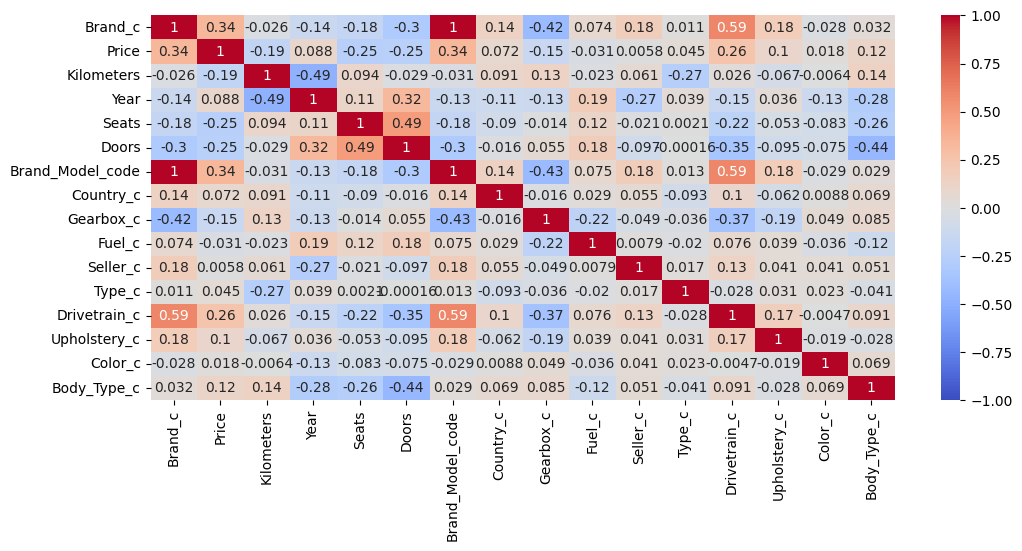

In [37]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr(), annot=True, vmin=-1, cmap='coolwarm')

In [ ]:
df_coches_caros = df[df['Price']>60000]
df_coches_baratos = df[df['Price']<=60000]

df_coches_caros.to_csv('../data/processed/coches_caros_procc.csv', index = False)
df_coches_baratos.to_csv('../data/processed/coches_baratos_procc.csv', index = False)

<Axes: xlabel='Price', ylabel='Count'>

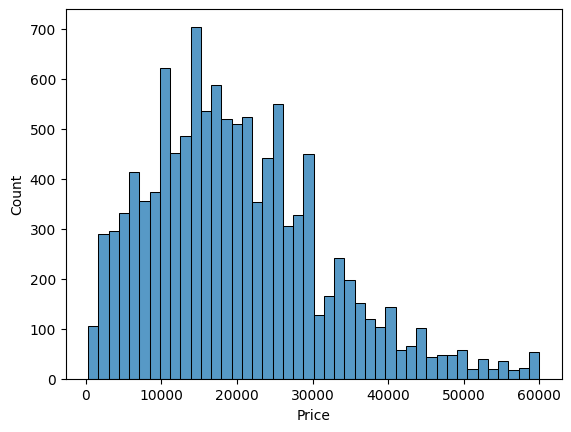

In [42]:
sns.histplot( df_coches_baratos['Price'])

<Axes: ylabel='Price'>

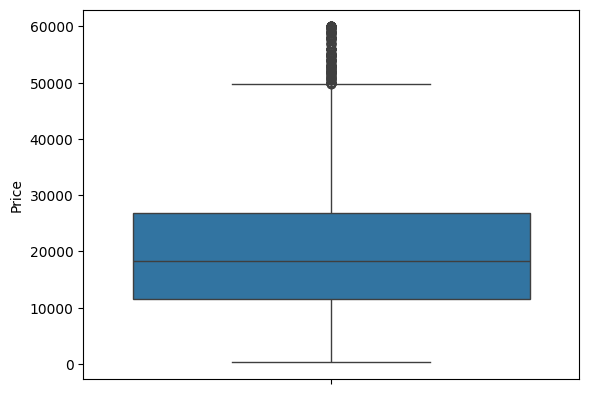

In [39]:
sns.boxplot(df_coches_baratos['Price'])

<Axes: xlabel='Price', ylabel='Count'>

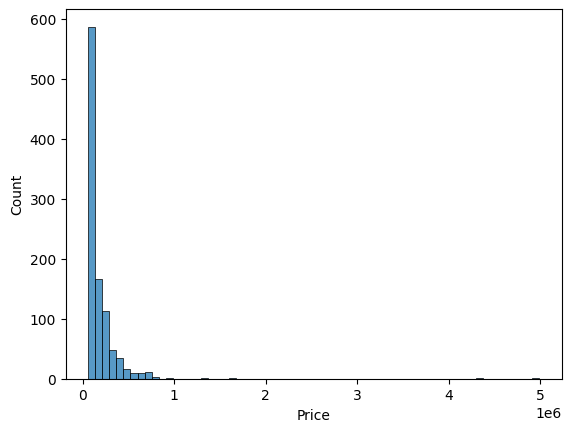

In [53]:
sns.histplot( df_coches_caros['Price'])

<Axes: ylabel='Price'>

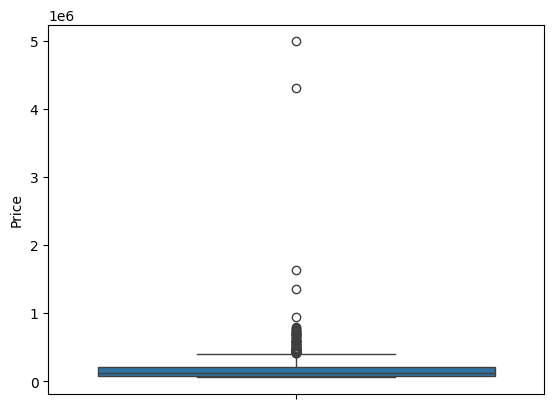

In [40]:
sns.boxplot(df_coches_caros['Price'])

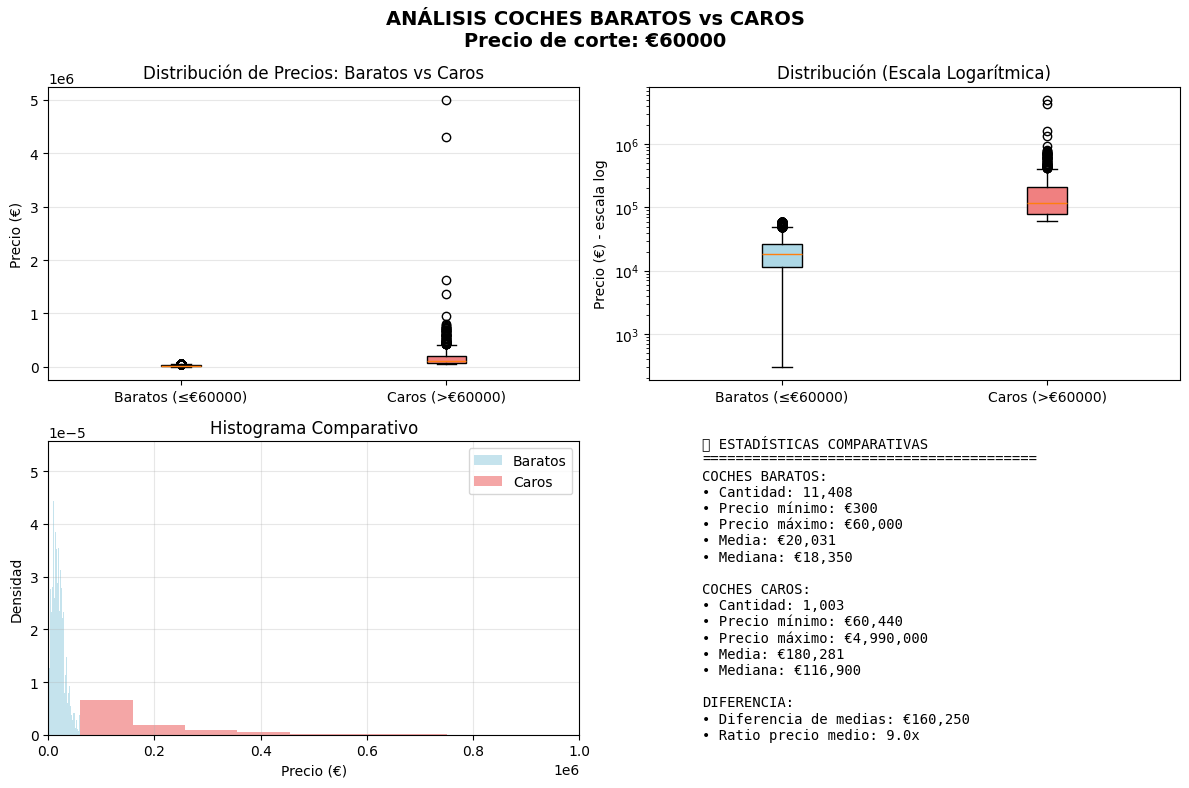

In [55]:
# BOXPLOT
plt.figure(figsize=(12, 8))

# Boxplot básico
plt.subplot(2, 2, 1)
box_data = [df_coches_baratos['Price'], df_coches_caros['Price']]
labels = [f'Baratos (≤€60000)', f'Caros (>€60000)']
box = plt.boxplot(box_data, labels=labels, patch_artist=True)

# Colores
colors = ['lightblue', 'lightcoral']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Distribución de Precios: Baratos vs Caros')
plt.ylabel('Precio (€)')
plt.grid(True, alpha=0.3, axis='y')

# Boxplot con escala logarítmica (para mejor visualización)
plt.subplot(2, 2, 2)
box_log = plt.boxplot(box_data, labels=labels, patch_artist=True)

for patch, color in zip(box_log['boxes'], colors):
    patch.set_facecolor(color)

plt.yscale('log')
plt.title('Distribución (Escala Logarítmica)')
plt.ylabel('Precio (€) - escala log')
plt.grid(True, alpha=0.3, axis='y')

# Histograma comparativo
plt.subplot(2, 2, 3)
plt.hist(df_coches_baratos['Price'], bins=50, alpha=0.7, label='Baratos', 
         color='lightblue', density=True)
plt.hist(df_coches_caros['Price'], bins=50, alpha=0.7, label='Caros', 
         color='lightcoral', density=True)
plt.xlim(0, 1000000)
plt.xlabel('Precio (€)')
plt.ylabel('Densidad')
plt.title('Histograma Comparativo')
plt.legend()
plt.grid(True, alpha=0.3)

# Estadísticas
plt.subplot(2, 2, 4)
plt.axis('off')

estadisticas_texto = (
    f"📈 ESTADÍSTICAS COMPARATIVAS\n"
    f"{'='*40}\n"
    f"COCHES BARATOS:\n"
    f"• Cantidad: {len(df_coches_baratos):,}\n"
    f"• Precio mínimo: €{df_coches_baratos['Price'].min():,.0f}\n"
    f"• Precio máximo: €{df_coches_baratos['Price'].max():,.0f}\n"
    f"• Media: €{df_coches_baratos['Price'].mean():,.0f}\n"
    f"• Mediana: €{df_coches_baratos['Price'].median():,.0f}\n"
    f"\nCOCHES CAROS:\n"
    f"• Cantidad: {len(df_coches_caros):,}\n"
    f"• Precio mínimo: €{df_coches_caros['Price'].min():,.0f}\n"
    f"• Precio máximo: €{df_coches_caros['Price'].max():,.0f}\n"
    f"• Media: €{df_coches_caros['Price'].mean():,.0f}\n"
    f"• Mediana: €{df_coches_caros['Price'].median():,.0f}\n"
    f"\nDIFERENCIA:\n"
    f"• Diferencia de medias: €{df_coches_caros['Price'].mean() - df_coches_baratos['Price'].mean():,.0f}\n"
    f"• Ratio precio medio: {df_coches_caros['Price'].mean()/df_coches_baratos['Price'].mean():.1f}x"
)

plt.text(0.1, 0.5, estadisticas_texto, fontsize=10, 
         verticalalignment='center', fontfamily='monospace')
plt.suptitle(f'ANÁLISIS COCHES BARATOS vs CAROS\nPrecio de corte: €60000', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

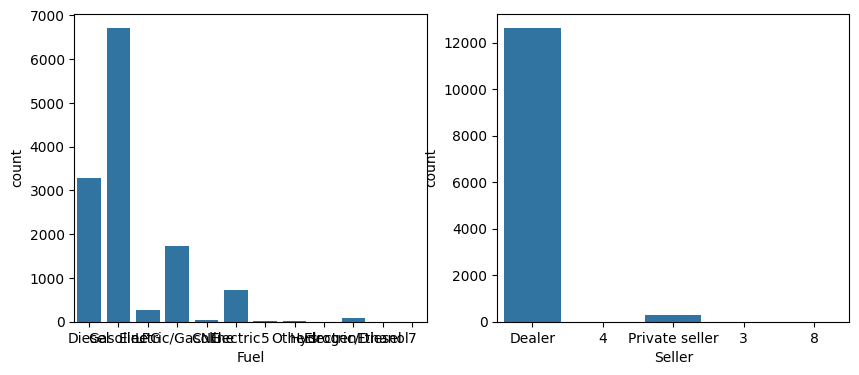

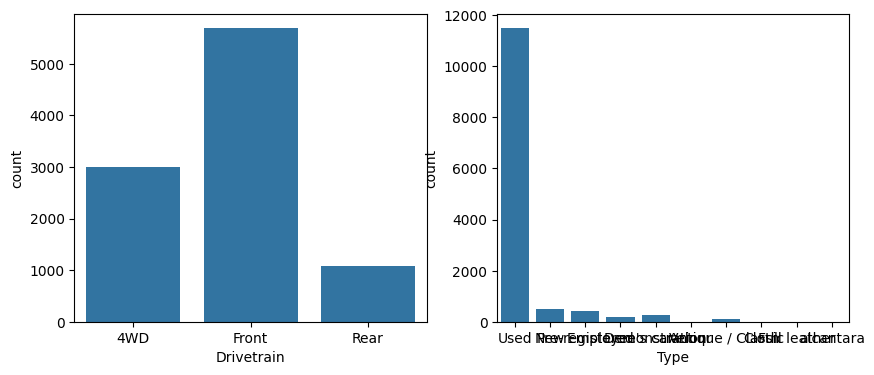

In [200]:
cat_cols = ['Fuel','Seller','Drivetrain','Type']
i=0
while i < 4:
    fig = plt.figure(figsize=[10,4])
    #ax1 = fig.add_subplot(121)
    #ax2 = fig.add_subplot(122)
    
    #ax1.title.set_text(cat_cols[i])
    plt.subplot(1,2,1)
    sns.countplot(x=cat_cols[i], data=data)
    i += 1
    
    #ax2.title.set_text(cat_cols[i])
    plt.subplot(1,2,2)
    sns.countplot(x=cat_cols[i], data=data)
    i += 1
    
    plt.show()

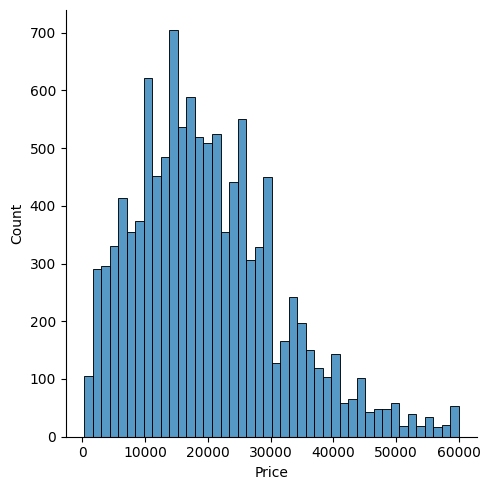

In [214]:
sns.displot(df_coches_baratos['Price']);

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12415 entries, 0 to 12903
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brand_c           12415 non-null  int64  
 1   Price             12415 non-null  float64
 2   Kilometers        12415 non-null  float64
 3   Year              12415 non-null  int64  
 4   Seats             12415 non-null  float64
 5   Doors             12415 non-null  float64
 6   Brand_Model_code  12415 non-null  float64
 7   Country_c         12415 non-null  int64  
 8   Gearbox_c         12415 non-null  int64  
 9   Fuel_c            12415 non-null  int64  
 10  Seller_c          12415 non-null  int64  
 11  Type_c            12415 non-null  int64  
 12  Drivetrain_c      12411 non-null  float64
 13  Upholstery_c      12415 non-null  int64  
 14  Color_c           12415 non-null  int64  
 15  Body_Type_c       12415 non-null  int64  
dtypes: float64(6), int64(10)
memory usage: 1.6 MB